In [1]:
import pandas as pd
from tqdm import tqdm
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.simplefilter(action='ignore')

'''Custom packages'''
from utility.light_utility import Utility
from geobleu import geobleu
from ttknn import ttknn

C:\Users\ss348\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Data Loading

In [2]:



tar_fold = 'dataset'
tar_path_list = []
for dir in os.listdir("./" + tar_fold):
    if dir.__contains__("cityA"): continue
    tar_dir = os.path.join(os.getcwd(), tar_fold, dir)
    if os.path.isdir(tar_dir) and dir.startswith("city"):

        tar_file = [ele for ele in os.listdir(tar_dir) if ele.endswith('.csv')][0]
        print(f"CSV file \033[1m{tar_file}\033[0m identified")
        tar_path = os.path.join(tar_dir, tar_file)
        tar_path_list.append(tar_path)
csv_file = pd.read_csv(tar_path_list[1]) # Only the second dataset is loaded


CSV file hiroshima_challengedata.csv identified
CSV file sapporo_challengedata.csv identified
CSV file kumamoto_challengedata.csv identified


# Data Filtering

In [3]:
uids_with_999 = csv_file[csv_file.x == 999].uid.unique()
target_segment = csv_file[~csv_file.uid.isin(uids_with_999)]

all_uids = target_segment.uid.unique()
train_df, test_df = Utility.test_train_split(target_segment, 60)


In [ ]:
dtw_score = {}

for uid in tqdm(all_uids[:3000]):
    sample = train_df[train_df.uid == uid]
    test_sample = test_df[test_df.uid == uid]

    submission_df = test_sample[['d', 't']]
    predicted = ttknn.temporal_knn_fit_predict(sample)
    s1 = Utility.to_eval_format(submission_df.merge(predicted, on='t', how='left'))
    s2 = Utility.to_eval_format(test_sample)
    dtw_score[uid] = geobleu.calc_dtw(s1, s2)


  0%|          | 0/3000 [00:00<?, ?it/s]

  2%|▏         | 60/3000 [03:27<2:39:38,  3.26s/it]

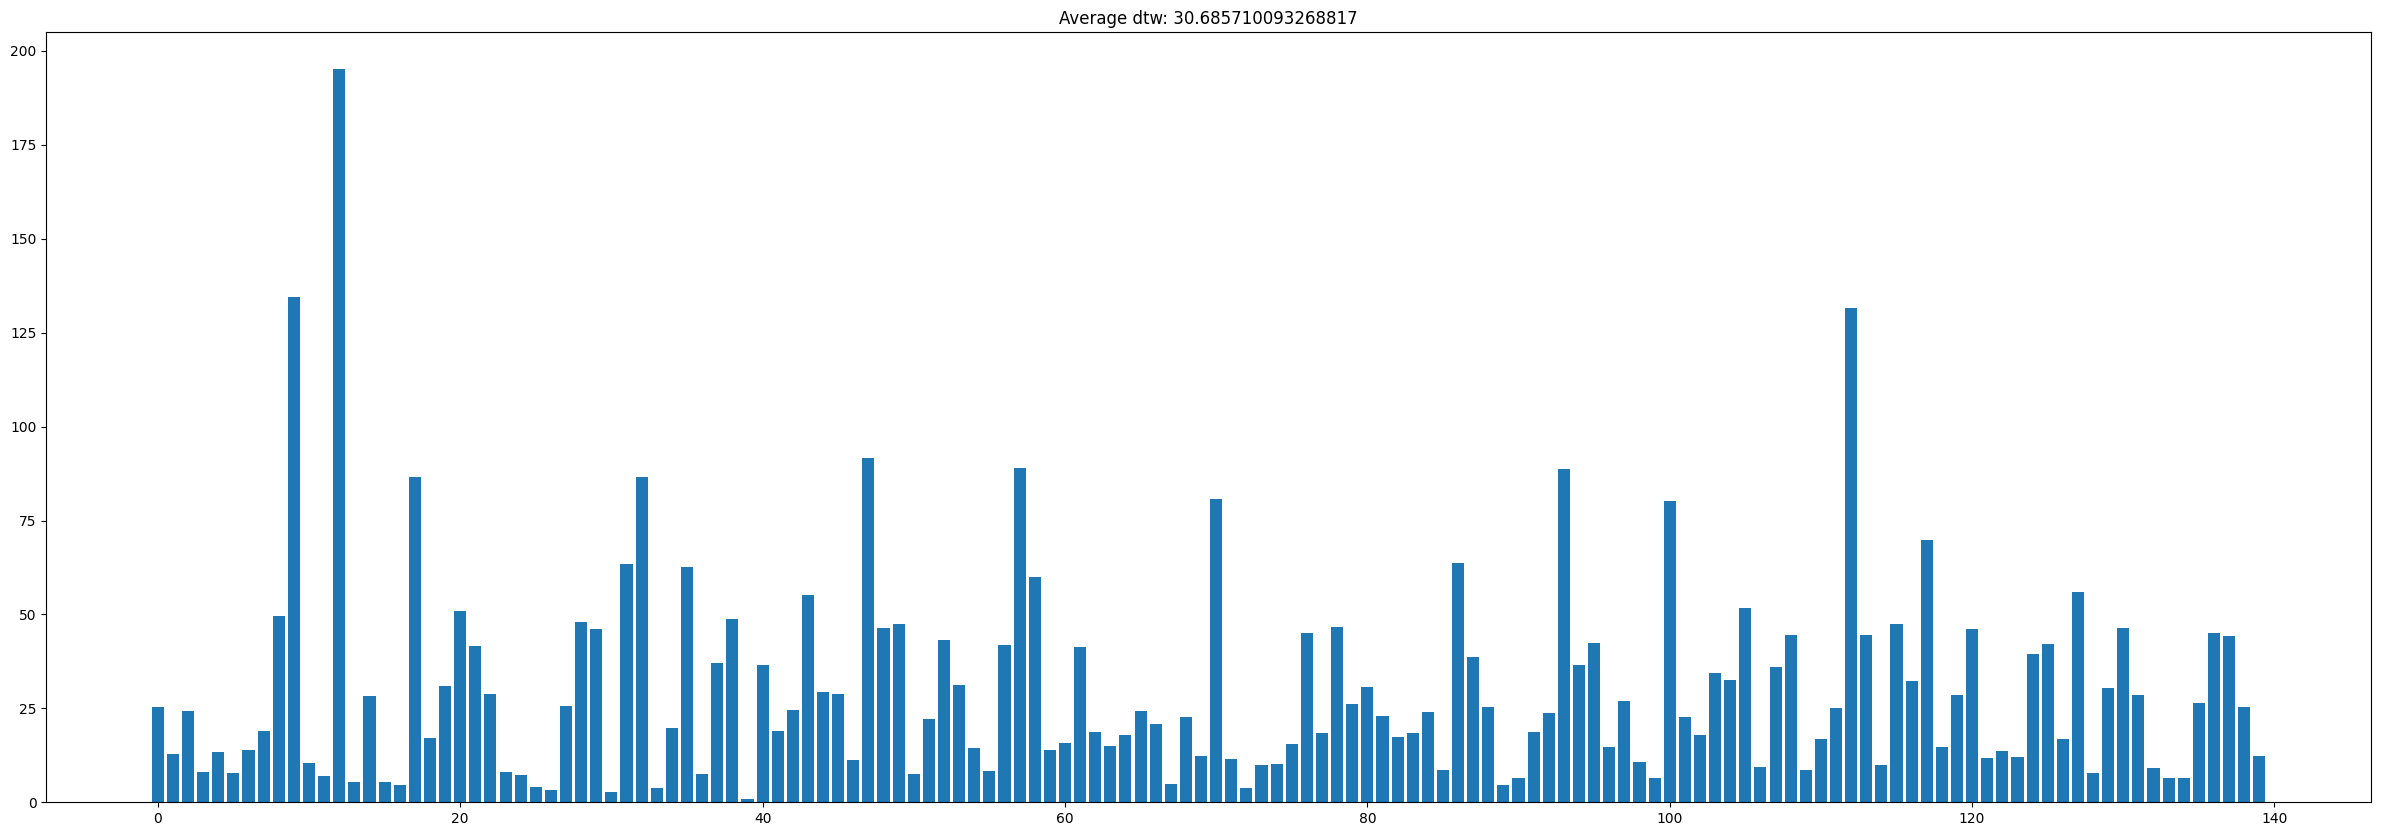

In [ ]:

scores = list(dtw_score.values())
means = np.mean(scores)
plt.figure(figsize=(30, 10))
plt.title(f"Average dtw: {means}")
plt.bar(list(dtw_score.keys()), scores)
plt.show()